In [1]:
import sympy as sp
import numpy as np


def Rx(q):
    return sp.Matrix([[1, 0, 0, 0],
                      [0, sp.cos(q), -sp.sin(q), 0],
                      [0, sp.sin(q), sp.cos(q), 0],
                      [0, 0, 0, 1]])


def Ry(q):
    return sp.Matrix([[sp.cos(q), 0, sp.sin(q), 0],
                      [0, 1, 0, 0],
                      [-sp.sin(q), 0, sp.cos(q), 0],
                      [0, 0, 0, 1]])


def Rz(q):
    return sp.Matrix([[sp.cos(q), -sp.sin(q), 0, 0],
                      [sp.sin(q), sp.cos(q), 0, 0],
                      [0, 0, 1, 0],
                      [0, 0, 0, 1]])


def Tx(d):
    return sp.Matrix([[1, 0, 0, d],
                      [0, 1, 0, 0],
                      [0, 0, 1, 0],
                      [0, 0, 0, 1]])


def Ty(d):
    return sp.Matrix([[1, 0, 0, 0],
                      [0, 1, 0, d],
                      [0, 0, 1, 0],
                      [0, 0, 0, 1]])


def Tz(d):
    return sp.Matrix([[1, 0, 0, 0],
                      [0, 1, 0, 0],
                      [0, 0, 1, d],
                      [0, 0, 0, 1]])


q1, q2, q3, q4, q5 = sp.symbols('q1 q2 q3 q4 q5')
d1, d2, d3, d4, d5, d6, d7, d8, d9, d10, d11 = sp.symbols(
    'd1 d2 d3 d4 d5 d6 d7 d8 d9 d10 d11')


In [2]:
def compute_Jacobian(T_matr, joints):
    pos = T_matr#[:3, 3]
    J = []
    for p in pos:
        Ji = []
        for j in joints:
            Ji.append(sp.diff(p, j))  # .simplify())
        J.append(Ji)
    J = sp.Matrix(J)
    return J

def inverse_Jacobian(J, qi):
    return sp.Matrix(np.linalg.pinv(J(float(qi[0]), float(qi[1]),
                                     float(qi[2]), float(qi[3]), float(qi[4]))))

def compute_error(des_pos, f, q, qi):
    vect = des_pos - sp.Matrix(f(float(qi[0]), float(qi[1]),
                                 float(qi[2]), float(qi[3]), float(qi[4])))
    angle = sp.Matrix([q(float(qi[0]), float(qi[1]),
                        float(qi[2]), float(qi[3]), float(qi[4]))]) 
    error = vect.row_insert(4, angle)
    dist = sp.sqrt(vect.dot(vect)).evalf()
    unit_dist = np.abs(angle[0])
    return dist, unit_dist, error


def inverse_kinematics(f, q, init_angle, des_pos, J, dt=0.001, Kp=10, max_dist=0.1):    
    dist_arr, vectors_arr = [], []
    qi = init_angle
    dist, unit_dist, error = compute_error(des_pos, f, q, qi)
    dist_arr.append(dist)
    vectors_arr.append(unit_dist)
    while dist > max_dist or unit_dist > 10**(-5):
        
        Jinv = inverse_Jacobian(J, qi)
        qi = (qi + dt * Jinv * Kp * (error)).evalf()
        dist, unit_dist, error = compute_error(des_pos, f, q, qi)
        
        print(f"{dist = }, {unit_dist = }, {len(vectors_arr) = }", end='\r')
        dist_arr.append(dist)
        vectors_arr.append(unit_dist)
    
    return qi, dist_arr, vectors_arr


In [5]:
q1m, q2m = sp.rad(30), sp.rad(-30)
l1 = 128
l2 = 175.5
l3 = 157.1
l4 = 145
# l5 = 80
d1 = 320.5
d2 = 130.5
d3 = 60
d4 = 60

T_base_0 = Rz(q1m) * Tz(l1) * Ty(l2) * Ry(q2m) * Tz(l3)
T01 = Ry(q1) * Ty(l4)
T12 = Rx(q2) * Tx(-d1)
T23 = Rz(q3) * Tx(-d2)
T34 = Rz(q4) * Tx(-d2)
T45 = Rz(q5) * Tx(-d4) * Tz(d3)

# Full transformation to end-effector
T05 = (T_base_0 * T01 * T12 * T23 * T34 * T45)#.applyfunc(sp.simplify)
f = T05[:3,3] # sp.simplify(T05[:3,3])

tx = -610
ty = 225
tz = 255
hole_ang = sp.rad(-90)
T_hole = Tx(tx) * Ty(ty) * Tz(tz) * Rz(hole_ang)

des_pos = T_hole[:3, 3]
des_or = T_hole[:3, 0]
q = 1 - (des_or.dot(T05[:3,0])) # sp.simplify(T05[:3,0])

joints = [q1, q2, q3, q4, q5]
J_dist = compute_Jacobian(f, joints)
J_angl = des_or.T * (compute_Jacobian(T05[:3, 0], joints))
J = sp.lambdify((q1, q2, q3, q4, q5), J_dist.row_insert(4, J_angl))

f_lambd = sp.lambdify((q1, q2, q3, q4, q5), f)
q_lambd = sp.lambdify((q1, q2, q3, q4, q5), q)
init_angle = sp.Matrix([np.deg2rad(0.00001)
                       for _ in range(len(joints))]).evalf()
T_hole



# def rot2eul(matrix):
#     alpha = sp.atan2(matrix[0, 2], -matrix[1, 2])
#     beta = sp.acos(matrix[2, 2])
#     gamma = sp.atan2(matrix[2, 0], matrix[2, 1])
#     return sp.Matrix([alpha, beta, gamma])

# target_vector = 1 - (target_orientation.dot(current_orientation))
# self.target_vector = sp.lambdify([thetas, target], target_vector)
#
# J_dist = jacobian_matrix(current_position, thetas)
# J_angl = target_orientation.T * (jacobian_matrix(current_orientation, thetas))
# self.jacobian = sp.lambdify([thetas, target], J_dist.row_insert(4, J_angl))


Matrix([
[ 0, 1, 0, -610],
[-1, 0, 0,  225],
[ 0, 0, 1,  255],
[ 0, 0, 0,    1]])

In [19]:
q_sol_arr, dist_arr, vectors_arr = inverse_kinematics(
    f_lambd, q_lambd, init_angle, des_pos, J)

q_sol_arr = [q for q in q_sol_arr]

print()
new_q_sol_arr = []
for a in q_sol_arr:
    a = a % (2 * sp.pi)    # force in range [0, 2 pi)
    if a > sp.pi:             # to [-pi, pi)
        a -= 2 * sp.pi
    print(sp.deg(a).evalf())
    new_q_sol_arr.append(a)


dist = 0.00157350948984733, unit_dist = 9.96536318476071e-6, len(vectors_arr) = 1186
36.5940608129210
-176.037184700423
130.496418976371
-119.709556944093
109.203794167301


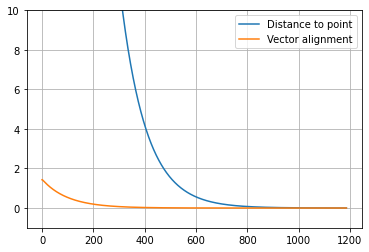

In [25]:
import matplotlib.pyplot as plt

plt.plot(dist_arr, label="Distance to point")
plt.plot(vectors_arr, label="Vector alignment")
plt.ylim(-1,10)
plt.legend()
plt.grid()


In [7]:
T05.subs({q: new_q_sol_arr[i] for i, q in enumerate(joints)}).evalf()

Matrix([
[ 0.00443432840591081,   0.959844780030074,    -0.280496586397422, -609.999343131182],
[  -0.999990082018431, 0.00437284226001739, -0.000845053453930078,  224.999396130379],
[0.000415447180188134,   0.280497551681984,     0.959854650925886,  215.000122642647],
[                   0,                   0,                     0,               1.0]])